In [4]:
import argparse
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow_probability as tfp
from utils.coco_dataset_manager import *
from utils.yolo_utils import *
from utils.custom_retinanet import prepare_image
from utils.nonmaxsuppression import *
from utils.negloglikely import nll
from utils.yolov8prob import ProbYolov8Detector
from PIL import Image
import matplotlib.pyplot as plt
import torch

tf.keras.backend.clear_session()
tf.compat.v1.enable_eager_execution()
torch.cuda.empty_cache()

# Hardcode paths and parameters
checkpoint_path = r"/remote_home/Thesis/Completed_Models/SoftmaxSum_mse"
image_folder = r"/remote_home/Thesis/DataFiles/small_test_videos/BDD_val_b1c9c847-3bda4659"
cls_path = r"/remote_home/Thesis/Prebayesian/class_list_traffic.txt"
download_path = r"/remote_home/Thesis/Prebayesian/download_list_traffic.txt"
loss_function = "mse"  # mse, cce, or pos
nms_layer = 'Softmax'  # Softmax or SoftmaxSum
min_confidence = 0.018
label_smoothing = 0

LEARNING_RATE = 0.0001
GLOBAL_CLIPNORM = 5

# Load the class lists from text; if not specified, it gets all 80 classes
cls_list = None
if cls_path:
    with open(cls_path) as f:
        cls_list = [cls.strip() for cls in f.readlines()]

print(cls_list)

download_list = None
if download_path and download_path != "False":
    with open(download_path) as f:
        download_lines = f.readlines()
        download_list = {line.split(",")[0]: line.split(",")[1].strip() for line in download_lines}

print(download_list)

# The detector will only be the length of the class list
num_classes = 80 if cls_list is None else len(cls_list)

print(num_classes)

# Augmenter and resizing
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"),
    ]
)
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
)

# Function to convert dictionary inputs to tuple
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

# NMS function
nms_fn = DistributionNMS if nms_layer == 'Softmax' else PreSoftSumNMS
detector = ProbYolov8Detector(num_classes, min_confidence=min_confidence, nms_fn=nms_fn)
label_smooth = max(min(label_smoothing, 1), 0)
classification_loss = keras.losses.MeanSquaredError(
    reduction="sum",
)
if loss_function == 'cce':
    classification_loss = keras.losses.CategoricalCrossentropy(
        reduction="sum", from_logits=True, label_smoothing=label_smooth
    )
if loss_function == 'pos':
    classification_loss = keras.losses.Poisson(
        reduction="sum"
    )

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, global_clipnorm=GLOBAL_CLIPNORM,
)
detector.model.compile(
    optimizer=optimizer, classification_loss=classification_loss, box_loss="ciou", jit_compile=False,
    box_loss_weight=7.5,
    classification_loss_weight=0.5,
)

print("Loading images...")
# Get a list of all image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
file_count = len(image_files)
print("Images loaded")

# Load detector Weights
detector.load_weights(checkpoint_path)
print("Detector loaded")

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.13; Detected an installation of version 2.12.0. Please upgrade TensorFlow to proceed.

2024-01-06 22:00:02.332461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 22:00:02.333727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 22:00:12.335865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 22:00:12.337793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 22:00:12.337861: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.23MiB (rounded to 9677056)requested by op yolov8_detector/model/stem_1_conv/Conv2D-0-Trans

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[1,3,898,898] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node yolov8_detector/model/stem_1_conv/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_19215]

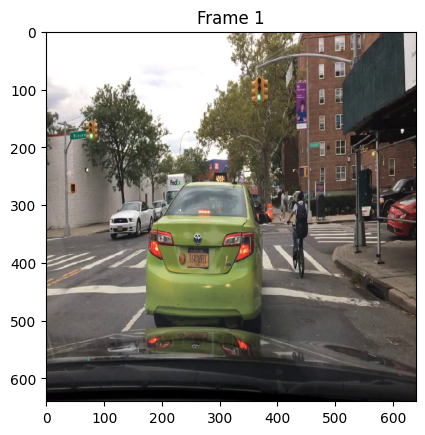

In [7]:
# Define a function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(640, 640))
    img_array = img_to_array(img)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32) / 255.0
    return img_tensor

# Assuming detector, cls_list, and image_files are defined in your code
detection_results = {}

# Define number of frames to show
max_frames_to_display = 5

for frame_number, frame_path in enumerate(image_files):
    frame = load_and_preprocess_image(os.path.join(image_folder, frame_path))
    
    # Display the loaded image using matplotlib
    plt.imshow(frame.numpy())
    plt.title(f"Frame {frame_number + 1}")

    # Perform object detection
    detections = detector(frame)
    boxes = np.asarray(detections["boxes"])
    cls_prob = np.asarray(detections["cls_prob"])
    cls_id = []

    # Creates list of id indices that meet minimum threshold
    for distribs in cls_prob:
        i = 0
        ids = []
        cur_min = np.min(distribs)
        for prob in distribs:
            if prob > cur_min + 0.005:
                ids.append(i)
            i += 1
        cls_id.append(ids)

    # Creates list of names corresponding to cls_id list
    cls_name = []
    for clses in cls_id:
        names = []
        for cls_n in clses:
            names.append(cls_list[cls_n])
        cls_name.append(names)
    
    # Creates list of probabilities associated with cls_id list
    correct_prob = []
    for i in range(len(cls_prob)):
        probs = []
        for ids in cls_id[i]:
            probs.append(cls_prob[i][ids])
        correct_prob.append(probs)
    
    # Visualize bounding boxes and class names
    for box, probs, cls_names in zip(boxes, cls_prob, cls_list):
        # Extract coordinates
        ymin, xmin, ymax, xmax = box

        # Draw bounding box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Display class name and confidence
        for prob, cls_name in zip(probs, cls_names):
            label = f"{cls_name}: {prob:.2f}"
            plt.text(xmin, ymin - 5, label, color='red')

    plt.show()
    if frame_number >= max_frames_to_display:
        break


2024-01-06 21:51:20.844556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 21:51:20.845401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 21:51:30.846483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 21:51:30.847325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 17.11MiB (17937152 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-06 21:51:30.847350: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.23MiB (rounded to 9677056)requested by op yolov8_detector/model/stem_1_conv/Conv2D-0-Trans

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[1,3,898,898] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node yolov8_detector/model/stem_1_conv/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_16574]

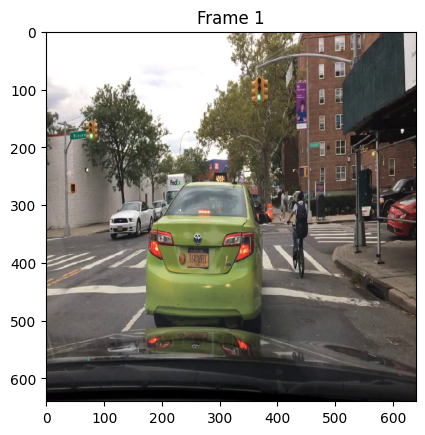

In [5]:
# Code with different method of sorting values for class probabilities

# Define a function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(640, 640))
    img_array = img_to_array(img)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32) / 255.0
    return img_tensor

# Assuming detector, cls_list, and image_files are defined in your code
detection_results = {}

# Define number of frames to show
max_frames_to_display = 4

for frame_number, frame_path in enumerate(image_files):
    frame = load_and_preprocess_image(os.path.join(image_folder, frame_path))
    
    # Create a new figure for each frame
    plt.figure()

    # Display the loaded image using matplotlib
    plt.imshow(frame.numpy())
    plt.title(f"Frame {frame_number + 1}")

    # Perform object detection
    detections = detector(frame)
    boxes = np.asarray(detections["boxes"])
    cls_prob = np.asarray(detections["cls_prob"])

    # Visualize bounding boxes and class names
    for box, prob_list in zip(boxes, cls_prob):
        cur_min = min(prob_list)
        
        # Select max probability and associated data to display
        probability = max(prob_list)
        
        if probability > cur_min + 0.001:
            print(f"Margin = {probability - cur_min}")

            chosen_class = np.argmax(prob_list)
            name = cls_list[chosen_class]

            # Extract coordinates
            ymin, xmin, ymax, xmax = box

            # Draw bounding box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
            plt.gca().add_patch(rect)

            # Add label
            label = f"{name}: {probability:.2f}"
            plt.text(xmin, ymin - 5, label, color='red')

    plt.show()
    if frame_number >= max_frames_to_display:
        break